In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime

sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
df = pd.read_csv("df_pymongo_new.csv")

In [3]:
df = df[df["timestamp"].notna()]
df = df[df["Company"].notna()]
df = df[df["Details"].notna()]
df = df[df["Title"].notna()]
df["timestamp"] = pd.to_datetime(df["timestamp"],infer_datetime_format=True)

def vraie_date(df):
    
    # Première fonction pour trouver l'unité de temps après "il y a"
    unit_dic = {"heure": "h", "jour":"D", "mois":"D", "minute":"m", "second":"second"}
    def unit_giver(jobby):
        temp = jobby
        for scale in unit_dic.keys():
            if scale in temp:
                temp = unit_dic[scale]
        return temp

    # Petite fonction pour enlever les symboles '+'
    def plus_remover(jobby):
        temp = jobby
        if "+" in temp:
            temp = temp[:-1]
        return pd.to_numeric(temp, errors='coerce')

    # Crée un tuple contenant les sorties des fonctions au-dessus pour
    # une ligne du dataset
    def time_diff(jobby):
        if "mois" not in jobby[1]:
            return plus_remover(jobby[0]), unit_giver(jobby[1])
        return 30*plus_remover(jobby[0]), unit_giver(jobby[1])
    
    

    return df["timestamp"] - df["Date"].apply(lambda x: time_diff(x[7:].split(" "))).apply(lambda x: pd.to_timedelta(x[0], unit=x[1]))

In [4]:
df["vraie_date"] = vraie_date(df)

In [6]:
past_28 = df.loc[(pd.datetime.today() - df["vraie_date"]).dt.days <= 28]
past_7 = df.loc[(pd.datetime.today() - df["vraie_date"]).dt.days <= 7]

In [7]:
day_job_counts = past_28["vraie_date"].dt.date.value_counts().sort_index().reset_index()
day_job_counts.columns = ["Date", "Offres"]
day_job_counts

,Date,Offres
0,2019-03-03,8
1,2019-03-04,61
2,2019-03-05,170
3,2019-03-06,148
4,2019-03-07,332
5,2019-03-08,579
6,2019-03-09,480
7,2019-03-10,273
8,2019-03-11,209
9,2019-03-12,58


In [9]:
df["Position Type"] = df["position"].fillna("Miscellaneous")

In [10]:
df.loc[df["Position Type"] == "analyst", "Position Type"] = "Data Analyst"
df.loc[df["Position Type"] == "scientist", "Position Type"] = "Data Scientist"
df.loc[df["Position Type"] == "Business_Intelligence", "Position Type"] = "Business Intelligence"


df["Position Type"].head()

0     Data Analyst
1     Data Analyst
2     Data Analyst
3     Data Analyst
5    Miscellaneous
Name: Position Type, dtype: object

In [11]:
past_28 = df.loc[(pd.datetime.today() - df["vraie_date"]).dt.days <= 28]
past_7 = df.loc[(pd.datetime.today() - df["vraie_date"]).dt.days <= 7]

In [12]:
dates_types = df[["vraie_date", "Position Type"]]
dates_types["Count"] = 1
dates_types["vraie_date"] = dates_types["vraie_date"].dt.date
#dates_types.groupby(by=dates_types.columns).sum()

jobby = dates_types.groupby(["vraie_date", "Position Type"]).count().reset_index()#.set_index(["vraie_date"])

C:\Users\Hugh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Hugh\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
jobby.head()

,vraie_date,Position Type,Count
0,2018-10-11,Business Intelligence,2
1,2018-10-11,Data Analyst,35
2,2018-10-11,Data Scientist,4
3,2018-10-11,Developpeur,6
4,2018-10-11,Miscellaneous,2


In [14]:
import itertools

vraie_date_col = pd.Series(pd.date_range(start=pd.datetime.today() - pd.Timedelta("28 days"), end=pd.datetime.today())).dt.date
pos_type_col = pd.Series(["Business Intelligence", "Data Analyst", "Data Scientist", "Developpeur", "Miscellaneous"])

def expand_grid(dct):
    rows = itertools.product(*dct.values())
    return pd.DataFrame.from_records(rows, columns=dct.keys())

In [15]:
pos_type_col

0    Business Intelligence
1             Data Analyst
2           Data Scientist
3              Developpeur
4            Miscellaneous
dtype: object

In [16]:
attempt = expand_grid({"date": vraie_date_col, "pos": pos_type_col})
attempt["Count2"] = 0
attempt2 = attempt.merge(jobby, how="left", left_on=["date", "pos"], right_on=["vraie_date", "Position Type"])
attempt3 = attempt2.drop(columns=["vraie_date", "Position Type"]).set_index(["date", "pos"])
date_pos_counts = attempt3.sum(axis=1)
date_pos_counts = date_pos_counts.reset_index()
date_pos_counts.columns = ["Date", "Position", "Number"]

bi_counts = date_pos_counts.loc[date_pos_counts["Position"] == "Business Intelligence"]
da_counts = date_pos_counts.loc[date_pos_counts["Position"] == "Data Analyst"]
ds_counts = date_pos_counts.loc[date_pos_counts["Position"] == "Data Scientist"]
de_counts = date_pos_counts.loc[date_pos_counts["Position"] == "Developpeur"]
mi_counts = date_pos_counts.loc[date_pos_counts["Position"] == "Miscellaneous"]

bi_counts = bi_counts.drop(columns=["Position"]).set_index("Date")
da_counts = da_counts.drop(columns=["Position"]).set_index("Date")
ds_counts = ds_counts.drop(columns=["Position"]).set_index("Date")
de_counts = de_counts.drop(columns=["Position"]).set_index("Date")
mi_counts = mi_counts.drop(columns=["Position"]).set_index("Date")

job_type_counts = pd.concat([de_counts, da_counts, ds_counts, bi_counts, mi_counts], axis=1)
job_type_counts.columns = ["Developpeur", "Data Analyst", "Data Scientist", "Business Intelligence", "Miscellaneous"]

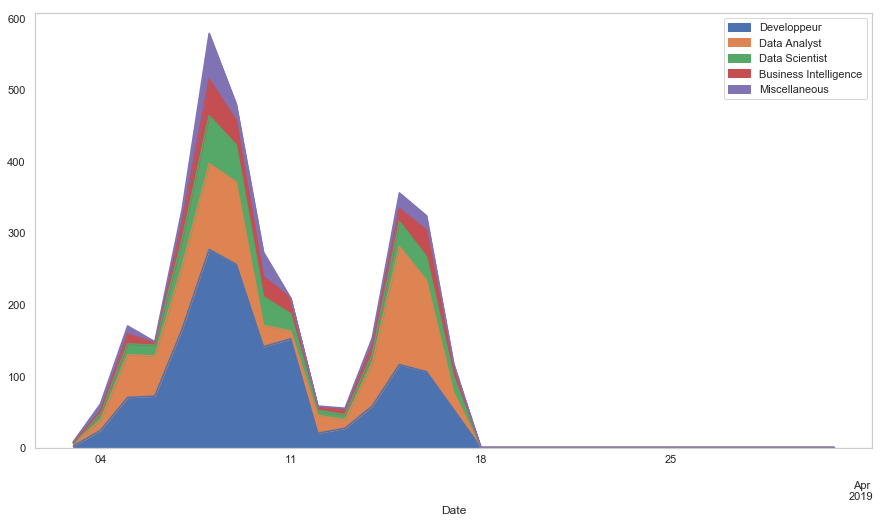

In [17]:
job_type_counts.plot.area(figsize=(15, 8))

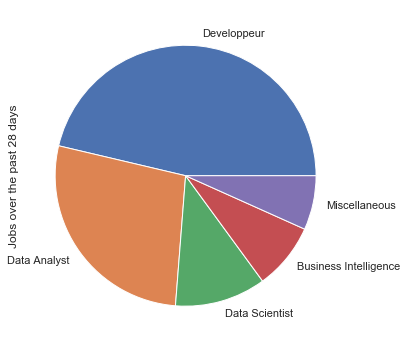

In [96]:
job_time_sum = job_type_counts.iloc[:,:].sum().to_frame() # For week, insert -7 before the first ':'
job_time_sum.columns = ["Jobs over the past 28 days"]
job_time_sum.plot.pie(y="Jobs over the past 28 days", figsize=(6,6), legend=False)#, title="Yay!")

In [32]:
df["Department"] = df["Location"].str.extract(r'(\d\d)', expand=False)
past_28["Department"] = past_28["Location"].str.extract(r'(\d\d)', expand=False)

C:\Users\Hugh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
dept_to_region = {"Hauts-de-France": ['02', "60", "80", "62", "59"], "Normandie": ["50", "14", "61", "27", "76"],
                  "Bretagne": ["29", "22", "35", "56"], "Grand Est": ["08", "51", "10", "52", "55", "54", "57", "88", "67", "68"],
                  "Pays de la Loire": ["53", "44", "72", "49", "85"], "Paris": ["75"],
                  "Banlieues": ["78", "95", "77", "91", "92", "93", "94"], "Centre Val de Loire": ["28", "18", "36", "37", "41", "45"],
                   "Bourgogne-Franche-Comté": ["89", "58", "21", "71", "70", "90", "25", "39"], 
                   "Auvergne-Rhone-Alpes": ["03", "63", "15", "43", "42", "07", "69", "26", "38", "01", "74", "73"], 
                  "Nouvelle Aquitaine": ["79", "86", "16", "17", "23", "87", "19", "24", "33", "47", "40", "64"],
                   "Occitanie": ["46", "12", "82", "81", "31", "32", "09", "65", "48", "30", "34", "11", "66"], 
                   "PACA": ["05", "06", "04", "83", "84", "13"]}

In [21]:
def to_region(x):
    for region in dept_to_region.keys():
        if x in dept_to_region[region]:
            return region
    return np.nan

def to_true_region(x):
    if to_region(x) in ["Paris", "Banlieues"]:
        return "Ile-de-France"
    return to_region(x)

In [33]:
past_28["Region"] = past_28["Department"].apply(to_true_region)

C:\Users\Hugh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
past_month = df.loc[(pd.datetime.today() - df["vraie_date"]).dt.days <= 28]

job_place_sum = past_month.set_index("vraie_date")["Region"].value_counts().reset_index()
job_place_sum.columns = ["Region", "Offres"]
job_place_sum

,Region,Offres
0,Ile-de-France,1187
1,Pays de la Loire,650
2,Occitanie,520
3,Nouvelle Aquitaine,480
4,Auvergne-Rhone-Alpes,245
5,PACA,17
6,Grand Est,10
7,Normandie,9
8,Centre Val de Loire,4


In [35]:
import geopandas as gpd

In [36]:
france_map = gpd.read_file("regions_2015_metropole_region.shp")

In [37]:
regions = list(dept_to_region.keys()) + ["Ile-de-France", "Corse"]
ordering = [3, 10, 9, 1, 8, 2, 7, 14, 13, 11, 0, 4, 12]
regions = [regions[i] for i in ordering]
regions

['Grand Est',
 'Nouvelle Aquitaine',
 'Auvergne-Rhone-Alpes',
 'Normandie',
 'Bourgogne-Franche-Comté',
 'Bretagne',
 'Centre Val de Loire',
 'Corse',
 'Ile-de-France',
 'Occitanie',
 'Hauts-de-France',
 'Pays de la Loire',
 'PACA']

In [87]:
france_map["Region"] = regions
france_map = france_map.set_index(["Region"])
france_map

,geometry,Offres,log_Offres,coords,Offres Developpeur,log_Offres Developpeur,Offres Data Analyst,log_Offres Data Analyst,Offres Data Scientist,log_Offres Data Scientist,Offres Business Intelligence,log_Offres Business Intelligence
Region,,,,,,,,,,,,
Grand Est,"POLYGON ((989978.2237081238 2359918.520042151,...",10.0,2.397895,"(849233.1988899617, 2429138.171674633)",4.0,1.386294,1.0,0.000000,5.0,1.609438,0.0,0.000000
Nouvelle Aquitaine,"(POLYGON ((529961.36291247 2002471.610732229, ...",480.0,6.175867,"(423581.454995475, 2000711.4536309303)",265.0,5.579730,86.0,4.454347,47.0,3.850148,37.0,3.610918
Auvergne-Rhone-Alpes,"POLYGON ((908678.6368602014 2021733.83701149, ...",245.0,5.505332,"(795618.9033268441, 2053628.500059939)",115.0,4.744932,54.0,3.988984,23.0,3.135494,28.0,3.332205
Normandie,"POLYGON ((554778.1631327126 2490377.054362766,...",9.0,2.302585,"(431062.8106378764, 2459497.00069949)",4.0,1.386294,2.0,0.693147,1.0,0.000000,2.0,0.693147
Bourgogne-Franche-Comté,"POLYGON ((947084.168399999 2280568.52758306, 9...",0.0,0.000000,"(794789.3975664644, 2254344.037038109)",0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
Bretagne,"(POLYGON ((283653.8216185604 2401966.0364222, ...",0.0,0.000000,"(213642.9739689027, 2363915.148440646)",0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
Centre Val de Loire,"POLYGON ((587060.4078828378 2158218.963189405,...",4.0,1.609438,"(552420.0786823796, 2294261.228868406)",3.0,1.098612,1.0,0.000000,0.0,0.000000,0.0,0.000000
Corse,"POLYGON ((1187309.208918364 1676949.610278987,...",0.0,0.000000,"(1155396.2761691296, 1712616.578648224)",0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
Ile-de-France,"POLYGON ((546804.2682356894 2453536.972533787,...",1187.0,7.080026,"(614053.2846182062, 2409250.235237613)",413.0,6.023448,515.0,6.244167,140.0,4.941642,83.0,4.418841


Text(0.5, 1.0, "Nombre d'Offres dans chaque Région")

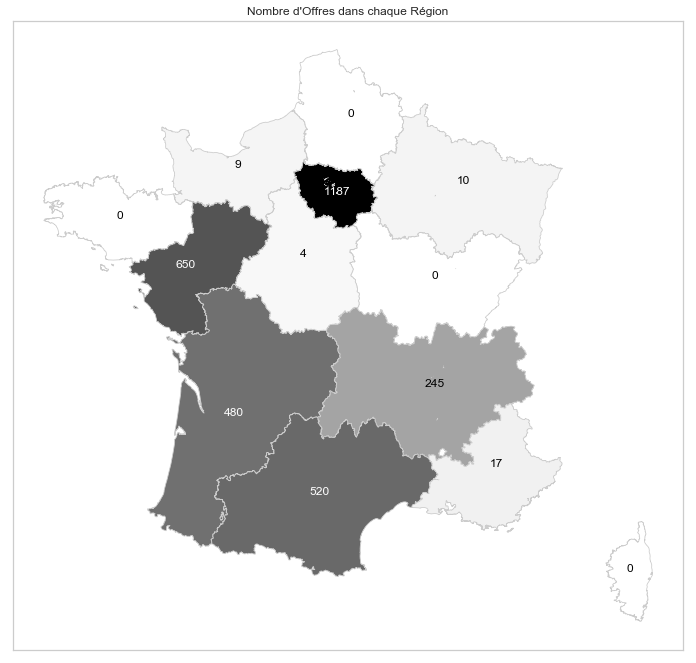

In [90]:
france_map["Offres"] = past_month["Region"].value_counts()
france_map["log_Offres"] = france_map["Offres"]**0.5 #np.log(france_map["Offres"] + 1)
france_map = france_map.fillna(0)

france_map['coords'] = france_map['geometry'].apply(lambda x: x.representative_point().coords[:])
france_map['coords'] = [coords[0] for coords in france_map['coords']]

fig1, ax1 = plt.subplots(figsize=(12,12))
france_map.plot(column="log_Offres", cmap="Greys", linewidth=0.8, edgecolor="0.8", ax=ax1)#, legend=True)
for idx, row in france_map.iterrows():
    if row["log_Offres"] > france_map["log_Offres"].max()/2:
        color = "white"
    else:
        color = "black"
    ax1.annotate(s=int(row['Offres']), xy=row['coords'],
                 horizontalalignment='center', color=color, fontsize=12)

ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_title("Nombre d'Offres dans chaque Région")

In [40]:
idf_depts = dept_to_region["Paris"] + dept_to_region["Banlieues"]
idf_depts
dept_job_counts = past_28["Department"].value_counts()[idf_depts].to_frame()
dept_job_counts.columns = ["Offres"]
dept_job_counts

,Offres
75,701
78,46
95,5
77,3
91,25
92,280
93,75
94,52


In [41]:
idf_map = gpd.read_file("geoflar-departements.shp")
idf_map

,id_geofla,code_dept,nom_dept,code_chf,nom_chf,x_chf_lieu,y_chf_lieu,x_centroid,y_centroid,code_reg,nom_reg,geometry
0,DEPARTEM0000000000000036,75,PARIS,101,PARIS,651679.0,6862426.0,650100.0,6862280.0,11,ILE-DE-FRANCE,"POLYGON ((2.279949332567544 48.87857312398175,..."
1,DEPARTEM0000000000000090,95,VAL-D'OISE,500,PONTOISE,634269.0,6883804.0,642235.0,6886661.0,11,ILE-DE-FRANCE,"POLYGON ((1.655983941548498 49.13038928200796,..."
2,DEPARTEM0000000000000030,92,HAUTS-DE-SEINE,050,NANTERRE,641614.0,6865913.0,644365.0,6856485.0,11,ILE-DE-FRANCE,"POLYGON ((2.220398136819997 48.92061341599004,..."
3,DEPARTEM0000000000000049,94,VAL-DE-MARNE,028,CRETEIL,659818.0,6853225.0,659881.0,6852859.0,11,ILE-DE-FRANCE,"POLYGON ((2.329063257287334 48.81378334679907,..."
4,DEPARTEM0000000000000023,78,YVELINES,646,VERSAILLES,636413.0,6856412.0,614838.0,6851681.0,11,ILE-DE-FRANCE,"POLYGON ((1.789382993057832 49.05785765015328,..."
5,DEPARTEM0000000000000052,77,SEINE-ET-MARNE,288,MELUN,674838.0,6826676.0,697961.0,6838051.0,11,ILE-DE-FRANCE,"POLYGON ((2.584074025346242 48.67715113677382,..."
6,DEPARTEM0000000000000089,91,ESSONNE,228,EVRY,657958.0,6836106.0,644635.0,6825888.0,11,ILE-DE-FRANCE,"POLYGON ((2.054809670511882 48.60795714161566,..."
7,DEPARTEM0000000000000014,93,SEINE-SAINT-DENIS,008,BOBIGNY,658860.0,6867904.0,659903.0,6867852.0,11,ILE-DE-FRANCE,"POLYGON ((2.292277257855158 48.95138905871919,..."


In [42]:
idf_map = idf_map.set_index("code_dept")
#idf_map.plot(figsize=(10,10))

In [43]:
idf_map['coords'] = idf_map['geometry'].apply(lambda x: x.representative_point().coords[:])
idf_map['coords'] = [coords[0] for coords in idf_map['coords']]
idf_map

,id_geofla,nom_dept,code_chf,nom_chf,x_chf_lieu,y_chf_lieu,x_centroid,y_centroid,code_reg,nom_reg,geometry,coords
code_dept,,,,,,,,,,,,
75,DEPARTEM0000000000000036,PARIS,101,PARIS,651679.0,6862426.0,650100.0,6862280.0,11,ILE-DE-FRANCE,"POLYGON ((2.279949332567544 48.87857312398175,...","(2.3199660447626185, 48.85797129247249)"
95,DEPARTEM0000000000000090,VAL-D'OISE,500,PONTOISE,634269.0,6883804.0,642235.0,6886661.0,11,ILE-DE-FRANCE,"POLYGON ((1.655983941548498 49.13038928200796,...","(2.2070741153612725, 49.074909044671244)"
92,DEPARTEM0000000000000030,HAUTS-DE-SEINE,050,NANTERRE,641614.0,6865913.0,644365.0,6856485.0,11,ILE-DE-FRANCE,"POLYGON ((2.220398136819997 48.92061341599004,...","(2.1992435325398363, 48.840476281809856)"
94,DEPARTEM0000000000000049,VAL-DE-MARNE,028,CRETEIL,659818.0,6853225.0,659881.0,6852859.0,11,ILE-DE-FRANCE,"POLYGON ((2.329063257287334 48.81378334679907,...","(2.454410119740812, 48.77486529371532)"
78,DEPARTEM0000000000000023,YVELINES,646,VERSAILLES,636413.0,6856412.0,614838.0,6851681.0,11,ILE-DE-FRANCE,"POLYGON ((1.789382993057832 49.05785765015328,...","(1.8901277781493344, 48.76142622325578)"
77,DEPARTEM0000000000000052,SEINE-ET-MARNE,288,MELUN,674838.0,6826676.0,697961.0,6838051.0,11,ILE-DE-FRANCE,"POLYGON ((2.584074025346242 48.67715113677382,...","(3.0405158271076287, 48.61946497320346)"
91,DEPARTEM0000000000000089,ESSONNE,228,EVRY,657958.0,6836106.0,644635.0,6825888.0,11,ILE-DE-FRANCE,"POLYGON ((2.054809670511882 48.60795714161566,...","(2.2404333592411474, 48.53014631015618)"
93,DEPARTEM0000000000000014,SEINE-SAINT-DENIS,008,BOBIGNY,658860.0,6867904.0,659903.0,6867852.0,11,ILE-DE-FRANCE,"POLYGON ((2.292277257855158 48.95138905871919,...","(2.452765056649117, 48.90988418151963)"


Text(0.5, 1.0, "Nombre d'Offres dans chaque Département")

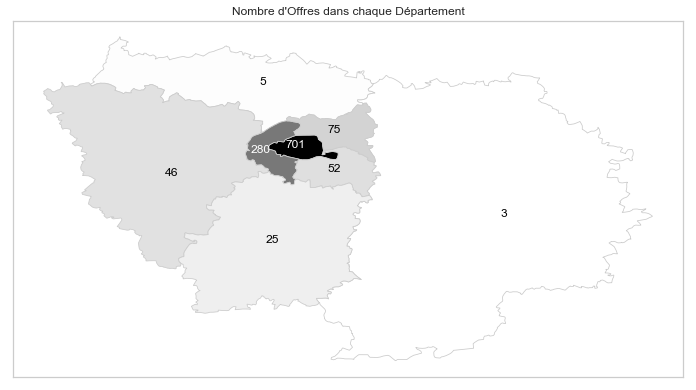

In [91]:
idf_map["Offres"] = dept_job_counts
idf_map["log_Offres"] = idf_map["Offres"]**0.5 #np.log(dept_job_counts)

fig2, ax2 = plt.subplots(figsize=(12,12))
idf_map.plot(column="log_Offres", cmap="Greys", linewidth=0.8, edgecolor="0.8", ax=ax2)#, legend=True)
for idx, row in idf_map.iterrows():
    if row["log_Offres"] > idf_map["log_Offres"].max()/2:
        color = "white"
    else:
        color = "black"
    ax2.annotate(s=int(row['Offres']), xy=row['coords'],
                 horizontalalignment='center', color=color, fontsize=12)

ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_title("Nombre d'Offres dans chaque Département")

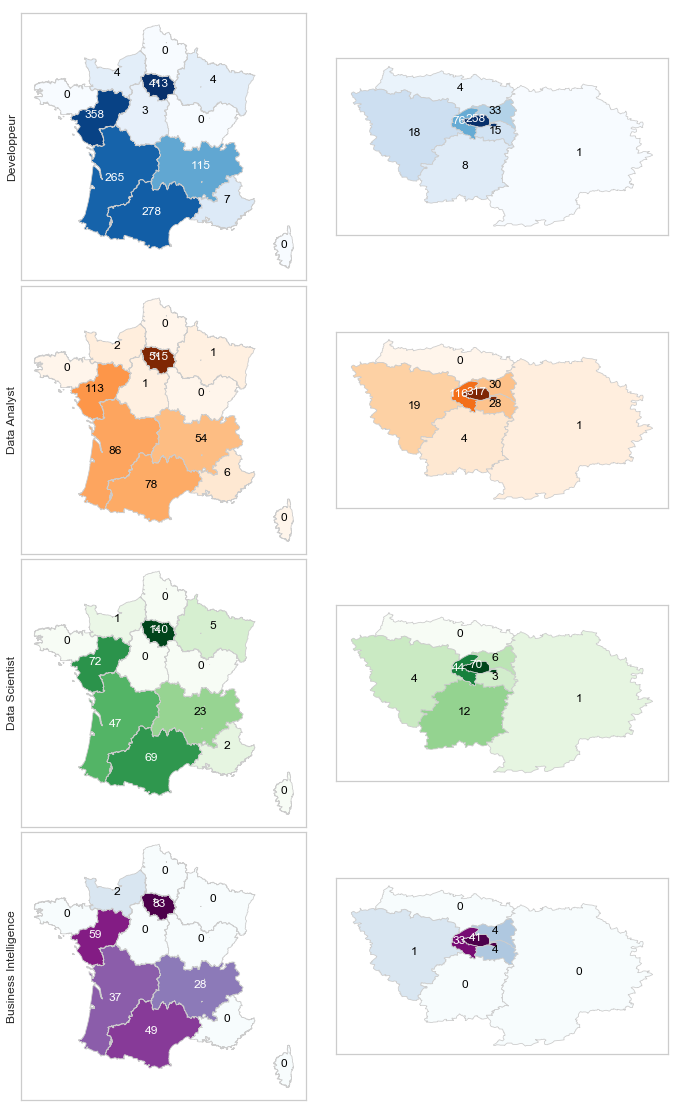

In [94]:
#france_map["Offres"] = past_28["Region"].value_counts()
#france_map["log_Offres"] = np.log(france_map["Offres"] + 1)
#france_map = france_map.fillna(0)

#idf_map["Offres"] = dept_job_counts
#idf_map["log_Offres"] = np.log(dept_job_counts + 1)

for job in ["Developpeur", "Data Analyst", "Data Scientist", "Business Intelligence"]:
    france_map["Offres " + job] = past_28.loc[past_28["Position Type"] == job, "Region"].value_counts()
    idf_map["Offres " + job] = past_28.loc[past_28["Position Type"] == job, "Department"].value_counts()
    france_map["log_Offres " + job] = france_map["Offres " + job]**0.5 #np.log(france_map["Offres " + job])
    idf_map["log_Offres " + job] = idf_map["Offres " + job]**0.5 #np.log(idf_map["Offres " + job])

france_map = france_map.fillna(0)
idf_map = idf_map.fillna(0)

france_map['coords'] = france_map['geometry'].apply(lambda x: x.representative_point().coords[:])
france_map['coords'] = [coords[0] for coords in france_map['coords']]

graphs = ["Developpeur", "Data Analyst", "Data Scientist", "Business Intelligence"] #["", 
graph_colors = ["Blues", "Oranges", "Greens", "BuPu"]
fig_off, ax_off = plt.subplots(4,2,figsize=(12,20))
fig_off.subplots_adjust(wspace=0.02, hspace=0.02)

for i in range(len(graphs)):
    france_map.plot(column="log_Offres " + graphs[i], cmap=graph_colors[i], linewidth=0.8, edgecolor="0.8", ax=ax_off[i,0])#, legend=True)
    for idx, row in france_map.iterrows():
        if row["log_Offres " + graphs[i]] > france_map["log_Offres " + graphs[i]].max()/2:
            color = "white"
        else:
            color = "black"
        ax_off[i,0].annotate(s=int(row['Offres ' + graphs[i]]), xy=row['coords'], 
                        horizontalalignment='center', color=color, fontsize=12)

    idf_map.plot(column="log_Offres " + graphs[i], cmap=graph_colors[i], linewidth=0.8, edgecolor="0.8", ax=ax_off[i,1])#, legend=True)
    for idx, row in idf_map.iterrows():
        if row["log_Offres " + graphs[i]] > idf_map["log_Offres " + graphs[i]].max()/2:
            color = "white"
        else:
            color = "black"
        ax_off[i,1].annotate(s=int(row['Offres ' + graphs[i]]), xy=row['coords'],
                 horizontalalignment='center', color=color, fontsize=12)
        
    ax_off[i,0].set_yticks([])
    ax_off[i,0].set_xticks([])
    ax_off[i,1].set_yticks([])
    ax_off[i,1].set_xticks([])
    ax_off[i,0].set_ylabel(graphs[i])
    
#ax_off[0,0].set_ylabel("Synthèse")

In [95]:
job_idf_counts = lambda job: past_28.loc[past_28["Position Type"] == job, "Department"].value_counts()

def idf_job_count(job):
    series = pd.Series(0, index = idf_map.index).to_frame().merge(job_idf_counts(job).to_frame(), how="left", left_index=True, right_index=True).max(axis=1)
    df = series.to_frame()
    df.columns = ["Offres"]
    return df